
[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
--- FASE 1: CREACIÓN DEL DATASET MAESTRO ---
✅ Facebook: Integrado (1000 filas).
✅ Instagram: Integrado (1000 filas).
✅ Twitter: Integrado (1000 filas).
✅ TikTok: Integrado (1000 filas).

✨ DATASET COMPLETADO: 4000 filas. Guardando backup...

--- FASE 2: ANÁLISIS EXPLORATORIO ---


/var/folders/gq/0hycmxgd3m55m0bqz27s6kjc0000gn/T/ipykernel_66941/375394369.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='platform', y='num_palabras', data=df, palette='Set2')


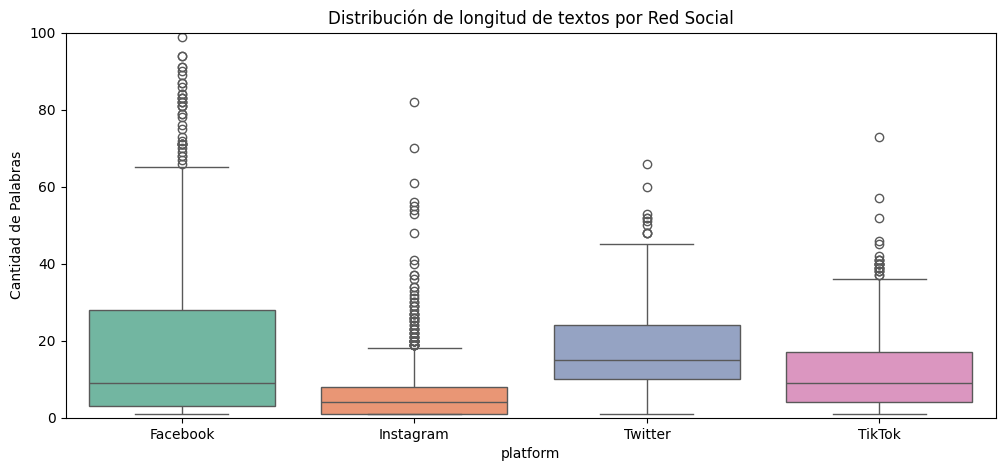

/var/folders/gq/0hycmxgd3m55m0bqz27s6kjc0000gn/T/ipykernel_66941/375394369.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='platform', data=df, palette='viridis')


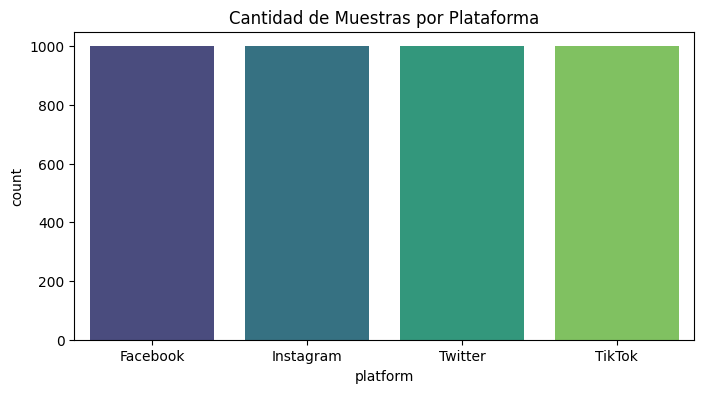


📊 Estadísticas de Longitud de Texto (Palabras):
            count    mean        std  min   25%   50%   75%    max
platform                                                          
Facebook   1000.0  29.441  61.178111  1.0   3.0   9.0  28.0  618.0
Instagram  1000.0   6.576   9.681216  1.0   1.0   4.0   8.0  145.0
TikTok     1000.0  11.500   9.997497  1.0   4.0   9.0  17.0   73.0
Twitter    1000.0  18.056  11.149941  1.0  10.0  15.0  24.0  127.0

🔥 Estadísticas de Engagement (Likes):
            count      mean           std  min    25%    50%    75%       max
platform                                                                     
Facebook      0.0       NaN           NaN  NaN    NaN    NaN    NaN       NaN
Instagram  1000.0     3.733     67.024578  0.0   1.00    1.0    1.0    2116.0
TikTok     1000.0     1.793     14.466493  0.0   0.00    1.0    2.0     373.0
Twitter    1000.0  3418.999  30457.906365  2.0  51.75  201.0  934.5  592538.0

💡 CONCLUSIÓN PARA EL MODELO:
El punto de 

In [1]:
#INSTALA LAS LIBRERÍAS NECESARIAS

%pip install pandas numpy matplotlib seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- 1. CONFIGURACIÓN EXACTA DE COLUMNAS ---
# Basado en tu output anterior, aquí mapeamos "nombre_original": "nombre_estandar"
config_archivos = {
    'Facebook': {
        'path': 'Datasets/Facebook.csv',
        'cols': {'comment_text': 'text', 'likes': 'likes'} # Nota: Revisa si Facebook tiene columna likes, si no, se rellenará con 0
    },
    'Instagram': {
        'path': 'Datasets/Instagram.csv',
        'cols': {'comment': 'text', 'likes_number': 'likes'} # ¡Aquí estaba el error antes!
    },
    'Twitter': {
        'path': 'Datasets/Twitter.csv',
        'cols': {'description': 'text', 'favorites': 'likes'} # Si 'favorites' no existe, ajustaremos abajo
    },
    'TikTok': {
        'path': 'Datasets/TikTok.csv',
        'cols': {'comment_text': 'text', 'digg_count': 'likes'} # Asumo digg_count, si falla, el código lo maneja
    }
}

dataframes = []

print("--- FASE 1: CREACIÓN DEL DATASET MAESTRO ---")

for platform, config in config_archivos.items():
    filepath = config['path']
    if os.path.exists(filepath):
        try:
            df_temp = pd.read_csv(filepath)
            
            # 1. Renombrar columnas clave (Texto)
            # Iteramos sobre el diccionario de columnas para renombrar
            df_temp.rename(columns=config['cols'], inplace=True)
            
            # 2. Asegurar que tenemos 'likes' (Engagement)
            # A veces la columna de likes tiene nombres raros, vamos a intentar pescarla si el renombrado falló
            if 'likes' not in df_temp.columns:
                # Buscamos cualquier columna que parezca numérica de likes
                col_likes = next((c for c in df_temp.columns if any(x in c.lower() for x in ['like', 'react', 'favorit', 'digg', 'heart'])), None)
                if col_likes:
                    df_temp.rename(columns={col_likes: 'likes'}, inplace=True)
                else:
                    df_temp['likes'] = 0 # Si no tiene likes (raro), ponemos 0
            
            # 3. Filtrar y Etiquetar
            if 'text' in df_temp.columns:
                subset = df_temp[['text', 'likes']].copy()
                subset['platform'] = platform
                subset['text'] = subset['text'].astype(str) # Asegurar que es texto
                dataframes.append(subset)
                print(f"✅ {platform}: Integrado ({len(subset)} filas).")
            else:
                print(f"⚠️ {platform}: No se encontró la columna de texto renombrada.")

        except Exception as e:
            print(f"❌ Error en {platform}: {e}")
    else:
        print(f"🚫 Archivo no encontrado: {filepath}")

# Unir todo
if dataframes:
    df = pd.concat(dataframes, ignore_index=True)
    # Limpieza final: Eliminar nulos y textos vacíos
    df.dropna(subset=['text'], inplace=True)
    df = df[df['text'].str.strip() != '']
    
    print(f"\n✨ DATASET COMPLETADO: {df.shape[0]} filas. Guardando backup...")
    df.to_csv('social_media_master.csv', index=False)
else:
    raise ValueError("No se pudo crear el dataset.")

# --- FASE 2: ANÁLISIS DE LAS COLUMNAS (EDA) ---
print("\n--- FASE 2: ANÁLISIS EXPLORATORIO ---")

# Calculamos longitud de los textos (número de palabras)
df['num_palabras'] = df['text'].apply(lambda x: len(str(x).split()))

# GRAFICO 1: Distribución de longitud de texto
# Esto es vital para definir el 'MAX_LEN' en la red neuronal
plt.figure(figsize=(12, 5))
sns.boxplot(x='platform', y='num_palabras', data=df, palette='Set2')
plt.title('Distribución de longitud de textos por Red Social')
plt.ylabel('Cantidad de Palabras')
plt.ylim(0, 100) # Hacemos zoom en los primeros 100
plt.show()

# GRAFICO 2: Balance de clases
# ¿Tenemos la misma cantidad de datos de cada red?
plt.figure(figsize=(8, 4))
sns.countplot(x='platform', data=df, palette='viridis')
plt.title('Cantidad de Muestras por Plataforma')
plt.show()

# ESTADÍSTICAS TEXTUALES
print("\n📊 Estadísticas de Longitud de Texto (Palabras):")
print(df.groupby('platform')['num_palabras'].describe())

# ESTADÍSTICAS DE ENGAGEMENT
print("\n🔥 Estadísticas de Engagement (Likes):")
print(df.groupby('platform')['likes'].describe())

# DEFINICIÓN DE VIRALIDAD
# Calculamos la mediana global para decidir qué es "Viral"
mediana_global = df['likes'].median()
print(f"\n💡 CONCLUSIÓN PARA EL MODELO:")
print(f"El punto de corte para considerar algo 'Viral' será: {mediana_global} likes.")

--- INICIANDO PROCESO CON NUEVOS NOMBRES DE ARCHIVO ---

--- PASO 1: CARGANDO Y UNIFICANDO ---
Index(['url', 'post_id', 'post_url', 'comment_id', 'user_name', 'user_id',
       'user_url', 'date_created', 'text', 'likes', 'num_replies',
       'attached_files', 'video_length', 'source_type', 'subtype', 'type',
       'platform'],
      dtype='object')
✅ Facebook: Cargado OK (0 filas).
Index(['url', 'comment_user', 'comment_user_url', 'comment_date', 'text',
       'likes', 'replies_number', 'replies', 'hashtag_comment',
       'tagged_users_in_comment', 'post_url', 'post_user', 'comment_id',
       'post_id', 'platform'],
      dtype='object')
✅ Instagram: Cargado OK (1000 filas).
Index(['id', 'user_posted', 'name', 'text', 'date_posted', 'photos', 'url',
       'tagged_users', 'replies', 'reposts', 'likes', 'views', 'external_url',
       'hashtags', 'followers', 'biography', 'posts_count',
       'profile_image_link', 'following', 'is_verified', 'quotes', 'bookmarks',
       'parent_

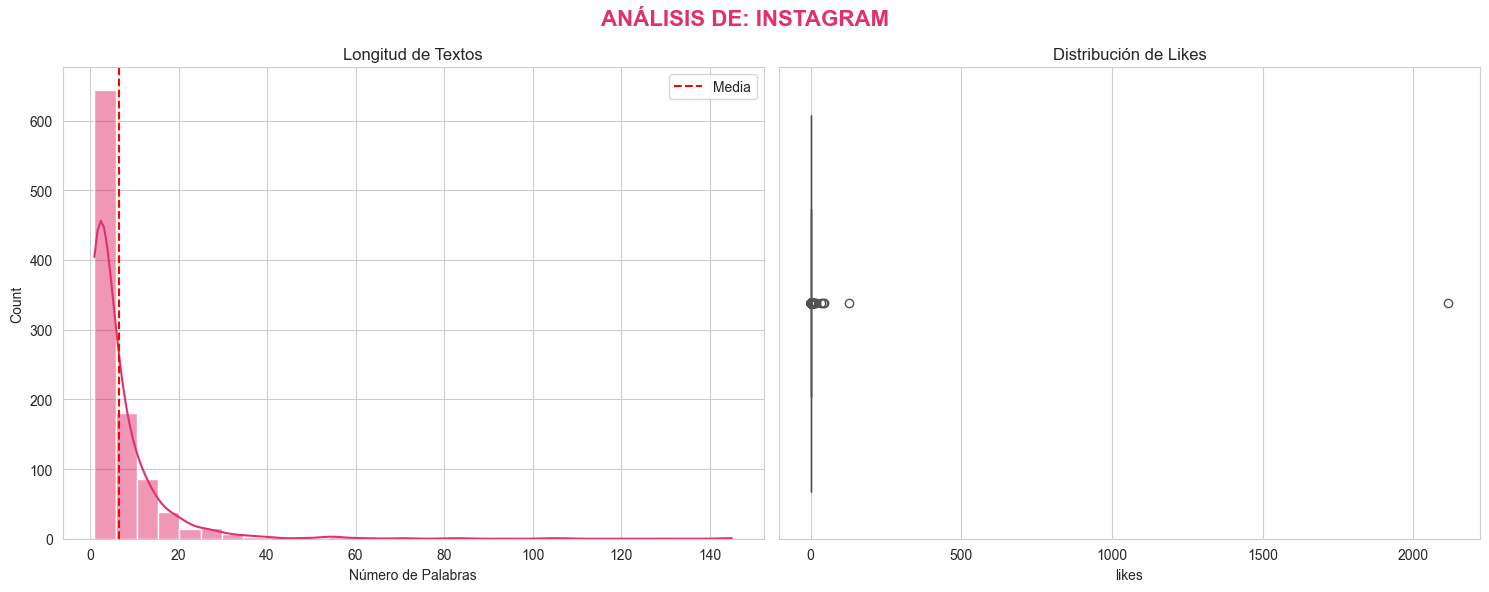

📝 Instagram -> Mediana Likes: 1.0 | Texto Medio: 6.6 palabras



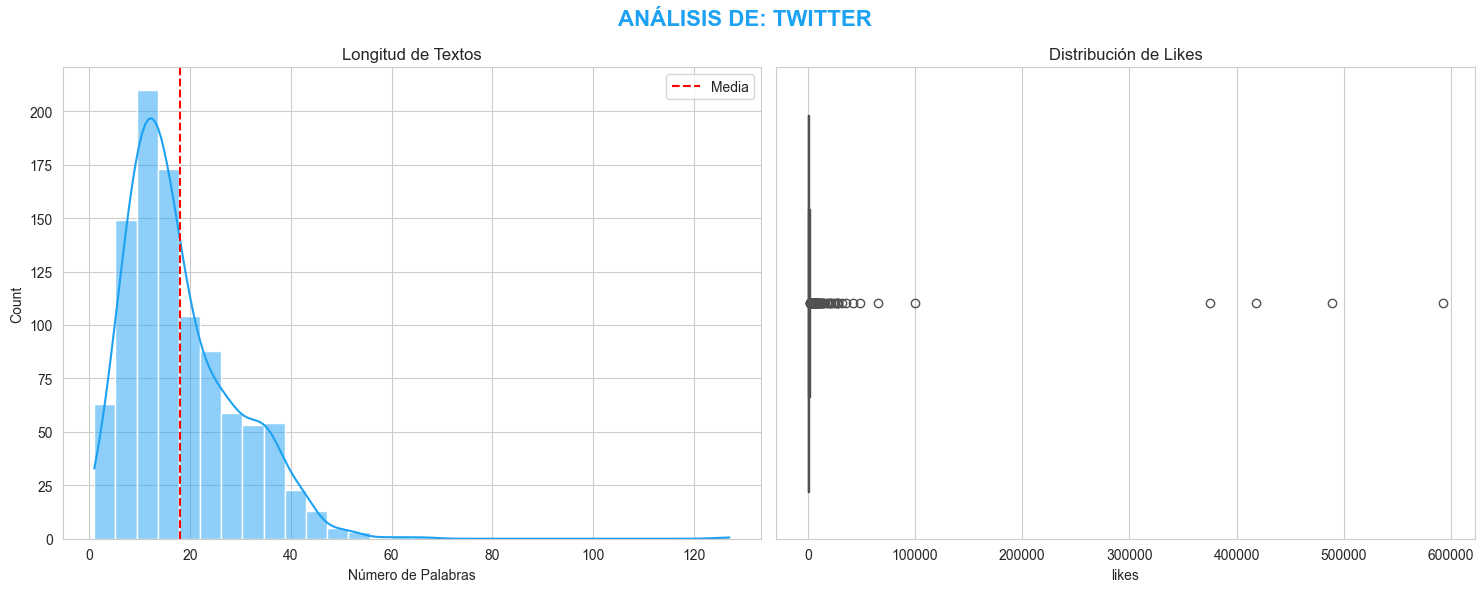

📝 Twitter -> Mediana Likes: 201.0 | Texto Medio: 18.1 palabras



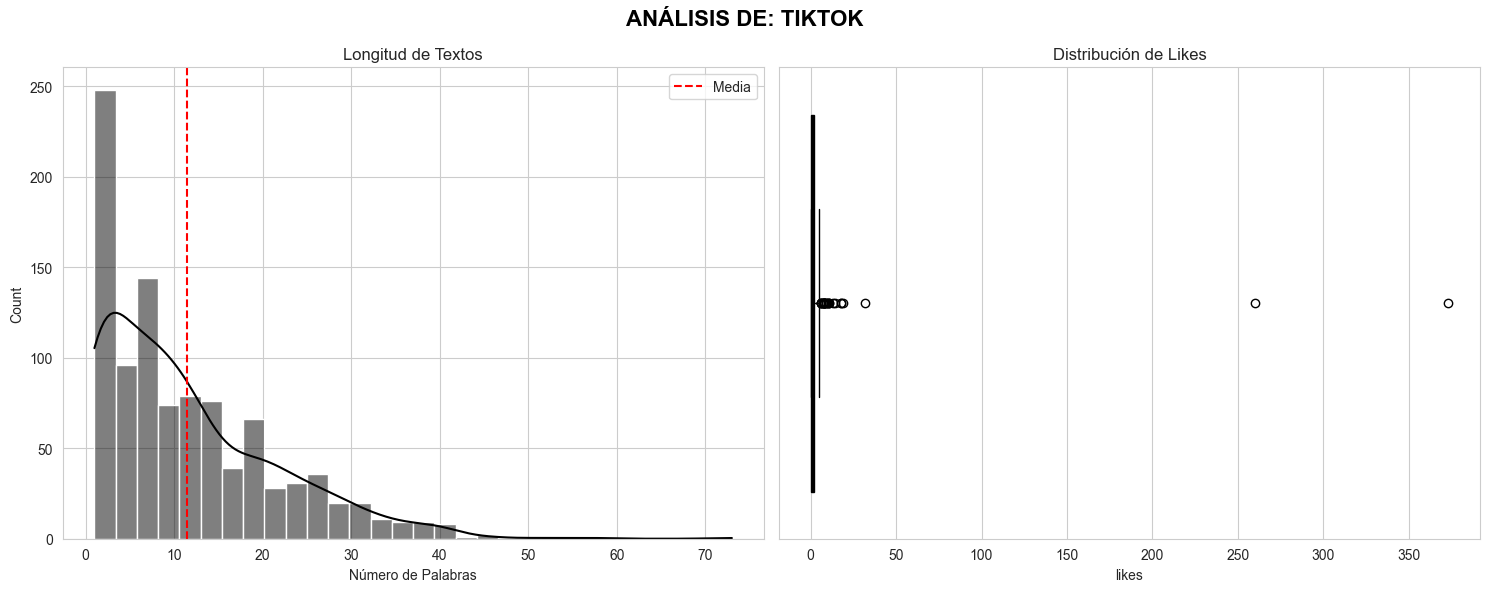

📝 TikTok -> Mediana Likes: 1.0 | Texto Medio: 11.5 palabras



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# ==========================================
# ⚙️ CONFIGURACIÓN DE ARCHIVOS (RUTAS NUEVAS)
# ==========================================
print("--- INICIANDO PROCESO CON NUEVOS NOMBRES DE ARCHIVO ---")

# Rutas exactas proporcionadas por ti
config_files = {
    'Facebook': {
        'path': 'Datasets/Facebook.csv', 
        'text_col': 'comment_text',
        'likes_col': 'num_likes'
    },
    'Instagram': {
        'path': 'Datasets/Instagram.csv',
        'text_col': 'comment',
        'likes_col': 'likes_number'
    },
    'Twitter': {
        'path': 'Datasets/Twitter.csv', 
        'text_col': 'description',
        'likes_col': 'favorites'
    },
    'TikTok': {
        'path': 'Datasets/TikTok.csv',
        'text_col': 'comment_text',
        'likes_col': 'num_likes'
    }
}

dataframes = []

# ==========================================
# 🚀 PASO 1: CARGA Y LIMPIEZA (ETL)
# ==========================================
print("\n--- PASO 1: CARGANDO Y UNIFICANDO ---")

for platform, config in config_files.items():
    filepath = config['path']
    
    if os.path.exists(filepath):
        try:
            # 1. Cargar CSV (saltando líneas corruptas si las hay)
            df_temp = pd.read_csv(filepath, on_bad_lines='skip')
            
            # 2. Renombrar columnas a 'text' y 'likes'
            # Usamos los nombres que tú has confirmado en la configuración
            columnas_a_renombrar = {}
            
            if config['text_col'] in df_temp.columns:
                columnas_a_renombrar[config['text_col']] = 'text'
            
            if config['likes_col'] in df_temp.columns:
                columnas_a_renombrar[config['likes_col']] = 'likes'
            
            df_temp.rename(columns=columnas_a_renombrar, inplace=True)

            # 3. Validar y Limpiar
            if 'text' in df_temp.columns and 'likes' in df_temp.columns:
                
                # --- LIMPIEZA ANTIBALAS ---
                # Convertir likes a números (borra "k", "M" o textos erróneos convirtiéndolos a NaN)
                df_temp['likes'] = pd.to_numeric(df_temp['likes'], errors='coerce')
                
                # Convertir texto a string y limpiar espacios
                df_temp['text'] = df_temp['text'].astype(str)
                df_temp = df_temp[df_temp['text'].str.strip() != 'nan']
                
                # Eliminar filas rotas (nulos en likes o texto)
                df_temp.dropna(subset=['text', 'likes'], inplace=True)
                
                # Añadir etiqueta de origen
                df_temp['platform'] = platform
                print(df_temp.columns)
                # Guardar en la lista
                dataframes.append(df_temp[['text', 'likes', 'platform']])
                print(f"✅ {platform}: Cargado OK ({len(df_temp)} filas).")
            else:
                # Si falla el renombrado exacto, mostramos qué columnas hay
                print(f"⚠️ {platform}: No se encontraron las columnas esperadas ({config['text_col']}, {config['likes_col']}).")
                print(f"   Columnas disponibles: {list(df_temp.columns)}")
                
        except Exception as e:
            print(f"❌ Error leyendo {platform}: {e}")
    else:
        print(f"🚫 Archivo no encontrado: {filepath}")

# ==========================================
# 🔄 PASO 2: CREACIÓN DEL DATASET FINAL
# ==========================================
if dataframes:
    df_master = pd.concat(dataframes, ignore_index=True)
    
    # Calcular longitud de palabras (Feature Engineering básica)
    df_master['num_palabras'] = df_master['text'].apply(lambda x: len(x.split()))
    
    print(f"\n✨ DATASET MAESTRO TOTAL: {len(df_master)} filas.")
    print(df_master['platform'].value_counts())
    
    # Guardar CSV limpio (Este es el que usaremos para la IA)
    df_master.to_csv('social_media_master.csv', index=False)
else:
    raise ValueError("¡No se cargó ningún dato! Verifica que la carpeta 'Datasets' existe y los nombres son correctos.")

# ==========================================
# 📊 PASO 3: VISUALIZACIÓN
# ==========================================
print("\n--- PASO 3: GENERANDO GRÁFICAS ---")
sns.set_style("whitegrid")

# Colores corporativos para estética
colores = {'Facebook': '#3b5998', 'Instagram': '#E1306C', 'Twitter': '#1DA1F2', 'TikTok': '#000000'}

for red in df_master['platform'].unique():
    subset = df_master[df_master['platform'] == red]
    color_red = colores.get(red, 'gray')
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'ANÁLISIS DE: {red.upper()}', fontsize=16, fontweight='bold', color=color_red)
    
    # Gráfica 1: Histograma de Palabras
    sns.histplot(subset['num_palabras'], kde=True, ax=axes[0], color=color_red, bins=30)
    axes[0].set_title(f'Longitud de Textos')
    axes[0].set_xlabel('Número de Palabras')
    axes[0].axvline(subset['num_palabras'].mean(), color='red', linestyle='--', label='Media')
    axes[0].legend()

    # Gráfica 2: Boxplot de Likes
    try:
        sns.boxplot(x=subset['likes'], ax=axes[1], color=color_red)
        axes[1].set_title(f'Distribución de Likes')
        
        # Escala logarítmica para ver mejor los datos virales
        if subset['likes' and 'num_likes'].max() > 0:
            axes[1].set_xscale('log')
            axes[1].set_xlabel('Likes (Escala Log)')
    except:
        pass

    plt.tight_layout()
    plt.show()

    # Resumen Numérico
    print(f"📝 {red} -> Mediana Likes: {subset['likes'].median()} | Texto Medio: {subset['num_palabras'].mean():.1f} palabras\n")

In [3]:
import nltk
import ssl

print("--- REPARANDO DESCARGAS DE NLTK ---")

# 1. TRUCO PARA MAC (Saltar verificación SSL)
# Esto soluciona el bloqueo de seguridad que impide descargar datos en Mac
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# 2. DESCARGAR RECURSOS MANUALMENTE
print("Descargando stopwords...")
nltk.download('stopwords')

print("Descargando wordnet (para lematización)...")
nltk.download('wordnet')
nltk.download('omw-1.4')

print("\n✅ ¡LISTO! Recursos descargados. Ahora vuelve a ejecutar el código de preprocesamiento.")

--- REPARANDO DESCARGAS DE NLTK ---
Descargando stopwords...
Descargando wordnet (para lematización)...

✅ ¡LISTO! Recursos descargados. Ahora vuelve a ejecutar el código de preprocesamiento.


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/n_benlloch/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/n_benlloch/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/n_benlloch/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
import pandas as pd
import numpy as np
import re
import nltk
import pickle
import ssl # Importamos ssl para prevenir el error en Mac
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ==========================================
# 1. CONFIGURACIÓN SEGURA PARA MAC
# ==========================================
print("--- FASE DE PREPROCESAMIENTO NLP ---")

# Fix para Mac SSL (por si acaso no corriste el script anterior)
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Descargas seguras
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# Carga del dataset
try:
    df = pd.read_csv('social_media_master.csv')
    df.dropna(subset=['text', 'likes'], inplace=True)
    df['text'] = df['text'].astype(str)
    print(f"📚 Dataset cargado: {len(df)} filas.")
except FileNotFoundError:
    raise ValueError("⚠️ No encuentro 'social_media_master.csv'.")

# ==========================================
# 2. LIMPIEZA Y LEMATIZACIÓN
# ==========================================
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def limpiar_texto_profundo(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    tokens = text.split()
    # Aquí aplicamos stopwords y lematización
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    
    return " ".join(tokens)

print("\n🧹 Limpiando textos...")
df['text_clean'] = df['text'].apply(limpiar_texto_profundo)

print(f"Ejemplo limpio: {df['text_clean'].iloc[0]}")

# ==========================================
# 3. PREPARACIÓN PARA RED NEURONAL
# ==========================================
print("\n--- CODIFICACIÓN (TOKENIZATION) ---")

MAX_WORDS = 5000
MAX_LEN = 50

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text_clean'])

word_index = tokenizer.word_index
print(f"🧠 Vocabulario: {len(word_index)} palabras.")

sequences = tokenizer.texts_to_sequences(df['text_clean'])
X = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')

# Target (Viralidad > Mediana)
mediana_likes = df['likes'].median()
y = (df['likes'] > mediana_likes).astype(int).values

# ==========================================
# 4. GUARDADO
# ==========================================
np.save('X_data.npy', X)
np.save('y_data.npy', y)

with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

print("\n💾 Archivos guardados: X_data.npy, y_data.npy, tokenizer.pickle")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


--- FASE DE PREPROCESAMIENTO NLP ---
📚 Dataset cargado: 3000 filas.

🧹 Limpiando textos...
Ejemplo limpio: 

--- CODIFICACIÓN (TOKENIZATION) ---
🧠 Vocabulario: 6690 palabras.

💾 Archivos guardados: X_data.npy, y_data.npy, tokenizer.pickle


In [5]:
%pip install numpy scikit-learn
import numpy as np
from sklearn.model_selection import train_test_split

# ==========================================
# 5. DIVISIÓN DEL DATASET (TRAIN / VAL / TEST)
# ==========================================
print("--- FASE DE DIVISIÓN DE DATOS (SPLITTING) ---")

# 1. Cargar las matrices procesadas (si vienes del paso anterior ya las tienes en memoria)
# Si reiniciaste VS Code, descomenta estas líneas:
# X = np.load('X_data.npy')
# y = np.load('y_data.npy')

print(f"📦 Datos totales disponibles: {len(X)} muestras")

# 2. PRIMERA DIVISIÓN: Separamos Train (70%) del resto (30%)
# random_state=42 asegura que siempre corte igual (reproducibilidad)
# stratify=y asegura que haya la misma proporción de virales en train que en test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.30, 
    random_state=42, 
    stratify=y 
)

# 3. SEGUNDA DIVISIÓN: El 30% restante lo partimos en dos mitades (15% Val / 15% Test)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.50, 
    random_state=42, 
    stratify=y_temp
)

# ==========================================
# VERIFICACIÓN DE TAMAÑOS
# ==========================================
print("\n✅ DIVISIÓN COMPLETADA:")
print(f"   1. TRAIN (Entrenamiento): {X_train.shape[0]} muestras ({(len(X_train)/len(X))*100:.1f}%)")
print(f"   2. VAL   (Validación):    {X_val.shape[0]} muestras ({(len(X_val)/len(X))*100:.1f}%)")
print(f"   3. TEST  (Evaluación):    {X_test.shape[0]} muestras ({(len(X_test)/len(X))*100:.1f}%)")

# Guardamos los sets definitivos para no mezclarlos nunca más
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

print("\n💾 Sets guardados en disco. ¡Listos para entrenar!")


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
--- FASE DE DIVISIÓN DE DATOS (SPLITTING) ---
📦 Datos totales disponibles: 3000 muestras

✅ DIVISIÓN COMPLETADA:
   1. TRAIN (Entrenamiento): 2100 muestras (70.0%)
   2. VAL   (Validación):    450 muestras (15.0%)
   3. TEST  (Evaluación):    450 muestras (15.0%)

💾 Sets guardados en disco. ¡Listos para entrenar!


--- CARGANDO DATOS PREPROCESADOS ---
✅ Datos cargados correctamente.

--- CONSTRUYENDO EL MODELO BASELINE (RNN) ---


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:100: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- ENTRENANDO... (Esto tomará unos segundos) ---
Epoch 1/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5124 - loss: 0.6937 - val_accuracy: 0.4956 - val_loss: 0.6956
Epoch 2/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4881 - loss: 0.6948 - val_accuracy: 0.4956 - val_loss: 0.6931
Epoch 3/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5405 - loss: 0.6877 - val_accuracy: 0.6889 - val_loss: 0.6245
Epoch 4/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.7714 - loss: 0.5381 - val_accuracy: 0.7089 - val_loss: 0.6233
Epoch 5/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.7948 - loss: 0.5035 - val_accuracy: 0.7200 - val_loss: 0.6194
Epoch 6/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8133 - loss: 0.4766 - val_accuracy: 0.7244 - val_loss: 0.5967
Epoch 7/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8257 - loss: 0.4567 - val_accuracy: 0.7244 - val_loss: 0.6249
Epoch 8/10
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accurac

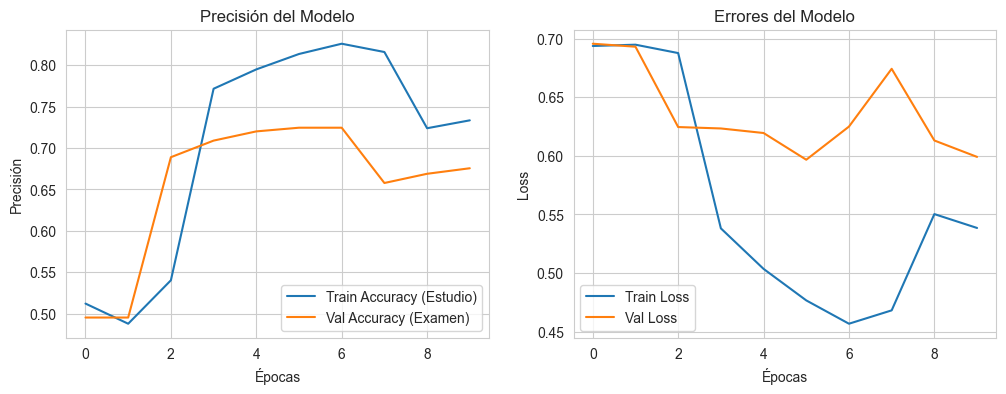


📢 NOTA FINAL EN TEST: 65.33% de acierto.
   (Este es el número que debemos intentar superar más adelante)


In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np

# ==========================================
# 1. CARGA DE DATOS (Fase previa)
# ==========================================
print("--- CARGANDO DATOS PREPROCESADOS ---")
try:
    X_train = np.load('X_train.npy')
    y_train = np.load('y_train.npy')
    X_val   = np.load('X_val.npy')
    y_val   = np.load('y_val.npy')
    X_test  = np.load('X_test.npy')
    y_test  = np.load('y_test.npy')
    print("✅ Datos cargados correctamente.")
except FileNotFoundError:
    raise ValueError("⚠️ No se encuentran los archivos .npy. Ejecuta el bloque de 'División del Dataset' primero.")

# ==========================================
# 2. DEFINICIÓN DEL BASELINE (Arquitectura)
# ==========================================
# Hiperparámetros del Baseline
VOCAB_SIZE = 5000  # (MAX_WORDS del paso anterior)
EMBEDDING_DIM = 32 # Dimensión pequeña para empezar
INPUT_LEN = 50     # (MAX_LEN del paso anterior)

print("\n--- CONSTRUYENDO EL MODELO BASELINE (RNN) ---")

model = Sequential([
    # CAPA 1: Embedding
    # Transforma cada palabra (número entero) en un vector de 32 números con significado.
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=INPUT_LEN),
    
    # CAPA 2: RNN Simple (El cerebro básico)
    # Usamos LSTM porque la 'SimpleRNN' clásica olvida muy rápido. 
    # Ponemos pocas neuronas (32) porque es un baseline.
    LSTM(32, return_sequences=False), 
    
    # CAPA 3: Output
    # 1 sola neurona con Sigmoid porque es clasificación binaria (0 o 1)
    Dense(1, activation='sigmoid')
])

model.summary()

# ==========================================
# 3. COMPILACIÓN Y ENTRENAMIENTO
# ==========================================
model.compile(optimizer='adam',
              loss='binary_crossentropy', # La pérdida estándar para Sí/No
              metrics=['accuracy'])

print("\n--- ENTRENANDO... (Esto tomará unos segundos) ---")

# Usamos validation_data para ver cómo se comporta en el examen parcial
history = model.fit(
    X_train, y_train,
    epochs=10,          # 10 pasadas completas
    batch_size=32,      # De 32 en 32 ejemplos
    validation_data=(X_val, y_val),
    verbose=1
)

# ==========================================
# 4. EVALUACIÓN Y GRÁFICAS
# ==========================================
print("\n--- RESULTADOS DEL BASELINE ---")

# Gráficas de rendimiento
plt.figure(figsize=(12, 4))

# Gráfica de Precisión (Accuracy)
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy (Estudio)')
plt.plot(history.history['val_accuracy'], label='Val Accuracy (Examen)')
plt.title('Precisión del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Gráfica de Pérdida (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Errores del Modelo')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Evaluación final en TEST (Datos nunca vistos)
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\n📢 NOTA FINAL EN TEST: {accuracy*100:.2f}% de acierto.")
print(f"   (Este es el número que debemos intentar superar más adelante)")

In [7]:
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("--- ENTRENANDO MODELO AVANZADO (PRO) ---")

# 1. Definir Arquitectura
model_pro = Sequential([
    # Embedding: Aumentamos la dimensión a 64 para captar más matices
    Embedding(input_dim=VOCAB_SIZE, output_dim=64, input_length=INPUT_LEN),
    
    # Dropout inicial para el embedding
    Dropout(0.3),
    
    # Capa BIDIRECCIONAL: La joya de la corona
    # Lee el texto en ambas direcciones. Duplica la potencia.
    Bidirectional(LSTM(64, return_sequences=True)), # return_sequences=True porque añadiremos otra capa
    Dropout(0.3),
    
    # Segunda capa LSTM (Profundidad)
    Bidirectional(LSTM(32)),
    
    # Capa Densa con regularización
    Dense(32, activation='relu'),
    Dropout(0.4),
    
    # Salida
    Dense(1, activation='sigmoid')
])

# 2. Compilación con Learning Rate dinámico
model_pro.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model_pro.summary()

# 3. Callbacks (Los "Árbitros" del entrenamiento)
# EarlyStopping: Si no mejora en 4 épocas, para.
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
# ReduceLROnPlateau: Si se atasca, reduce la velocidad de aprendizaje para afinar.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001)

# 4. Entrenamiento
history_pro = model_pro.fit(
    X_train, y_train,
    epochs=20, # Ponemos 20, pero parará antes gracias al EarlyStopping
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# 5. Evaluación Comparativa
loss_pro, acc_pro = model_pro.evaluate(X_test, y_test, verbose=0)
print(f"\n🏆 RESULTADO FINAL MODELO PRO: {acc_pro*100:.2f}%")
print(f"(Compara esto con tu baseline anterior)")

--- ENTRENANDO MODELO AVANZADO (PRO) ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.6333 - loss: 0.6382 - val_accuracy: 0.6578 - val_loss: 0.6153 - learning_rate: 0.0010
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - accuracy: 0.7810 - loss: 0.4896 - val_accuracy: 0.7356 - val_loss: 0.5300 - learning_rate: 0.0010
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.8738 - loss: 0.3434 - val_accuracy: 0.7333 - val_loss: 0.5725 - learning_rate: 0.0010
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.9043 - loss: 0.2702 - val_accuracy: 0.7356 - val_loss: 0.6790 - learning_rate: 0.0010
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.9257 - loss: 0.2179 - val_accuracy: 0.7400 - val_loss: 0.7912 - learning_rate: 5.0000e-04
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.9367 - loss: 0.1980 - val_accuracy: 0.7444 - val_loss: 0.7788 - learning_rate: 5.0000e-04

🏆 RESULTADO FINAL MODELO PRO: 71.56%
(Compara esto con tu baseline anterior)



--- ANÁLISIS DE ERRORES (AUDITORÍA) ---
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


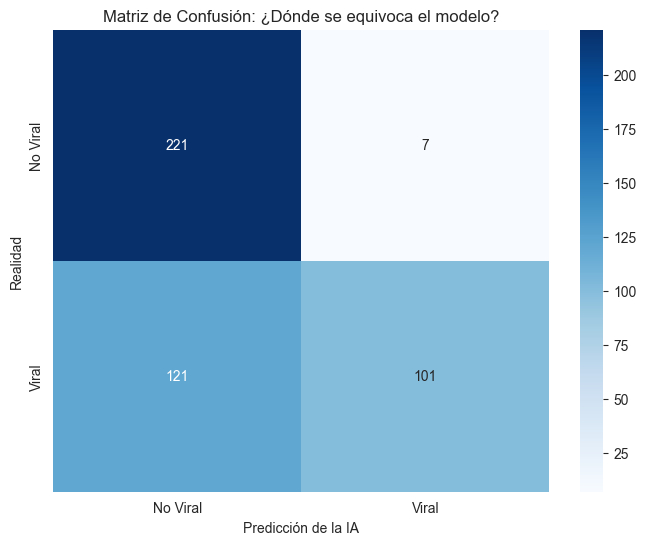


📑 REPORTE DE CLASIFICACIÓN:
              precision    recall  f1-score   support

    No Viral       0.65      0.97      0.78       228
       Viral       0.94      0.45      0.61       222

    accuracy                           0.72       450
   macro avg       0.79      0.71      0.69       450
weighted avg       0.79      0.72      0.69       450



In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("\n--- ANÁLISIS DE ERRORES (AUDITORÍA) ---")

# 1. Predecir sobre el Test Set
y_pred_prob = model_pro.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int) # Convertir probabilidad a 0 o 1

# 2. Generar Matriz
cm = confusion_matrix(y_test, y_pred)

# 3. Visualizar
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Viral', 'Viral'], yticklabels=['No Viral', 'Viral'])
plt.xlabel('Predicción de la IA')
plt.ylabel('Realidad')
plt.title('Matriz de Confusión: ¿Dónde se equivoca el modelo?')
plt.show()

# 4. Reporte detallado (Precision, Recall, F1)
print("\n📑 REPORTE DE CLASIFICACIÓN:")
print(classification_report(y_test, y_pred, target_names=['No Viral', 'Viral']))

In [9]:
print("\n--- DEMOSTRACIÓN EN VIVO ---")

# Función para usar el modelo
def predecir_viralidad(texto_nuevo):
    # 1. Limpiar igual que en el entrenamiento
    texto_limpio = limpiar_texto_profundo(texto_nuevo) # Usamos la función del paso 4
    
    # 2. Convertir a números (usando el tokenizer guardado)
    seq = tokenizer.texts_to_sequences([texto_limpio])
    
    # 3. Padding
    padded = pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')
    
    # 4. Predecir
    probabilidad = model_pro.predict(padded)[0][0]
    
    # 5. Resultado visual
    etiqueta = "🔥 VIRAL" if probabilidad > 0.5 else "❄️ NORMAL"
    color = "\033[92m" if probabilidad > 0.5 else "\033[94m" # Colores para terminal
    
    print(f"Texto: '{texto_nuevo}'")
    print(f"Predicción: {color}{etiqueta} ({probabilidad*100:.1f}% de probabilidad)\033[0m")
    print("-" * 50)

# --- PRUEBA TUS PROPIAS FRASES ---
mis_frases = [
    "Just drinking water today.", 
    "MEGA GIVEAWAY! Follow and like to win a new iPhone 15 Pro Max! #contest",
    "I am feeling very sad today because it is raining.",
    "Check out this amazing tutorial regarding data science and python.",
    "OMG look at this cute puppy dancing! 😍"
]

for frase in mis_frases:
    predecir_viralidad(frase)


--- DEMOSTRACIÓN EN VIVO ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Texto: 'Just drinking water today.'
Predicción: ❄️ NORMAL (32.7% de probabilidad)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
Texto: 'MEGA GIVEAWAY! Follow and like to win a new iPhone 15 Pro Max! #contest'
Predicción: 🔥 VIRAL (89.9% de probabilidad)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Texto: 'I am feeling very sad today because it is raining.'
Predicción: 🔥 VIRAL (62.9% de probabilidad)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Texto: 'Check out this amazing tutorial regarding data science and python.'
Predicción: ❄️ NORMAL (39.2% de probabilidad)
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Texto: 'OMG look at this cute puppy dancing! 😍'
Predicción: ❄️ NORMAL (39.7% de probabilidad)
-------------------------------------------------

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# ==========================================
# 1. PREPARACIÓN DE LA HERRAMIENTA
# ==========================================
print("\n🚀 INICIANDO SISTEMA DE PREDICCIÓN DE VIRALIDAD...")



# Aseguramos que tenemos todo lo necesario en memoria
if 'model_pro' not in globals() or 'tokenizer' not in globals():
    raise ValueError("⚠️ Error: No encuentro el modelo entrenado. Ejecuta el paso de entrenamiento primero.")

# Recuperamos la función de limpieza (por si acaso)
def limpieza_para_prediccion(text):
    # Esta función debe ser IDÉNTICA a la usada en el entrenamiento
    text = str(text).lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lematización rápida
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

def analizar_frase(frase_usuario):
    # 1. Limpieza
    frase_limpia = limpieza_para_prediccion(frase_usuario)
    
    # 2. Convertir texto a números (Tokenización)
    # Usamos el tokenizer que ya "aprendió" el vocabulario durante el entrenamiento
    secuencia = tokenizer.texts_to_sequences([frase_limpia])
    
    # 3. Padding (Relleno hasta 50 palabras)
    padded = pad_sequences(secuencia, maxlen=MAX_LEN, padding='post', truncating='post')
    
    # 4. Predicción del Modelo
    probabilidad = model_pro.predict(padded, verbose=0)[0][0]
    
    return probabilidad

# ==========================================
# 2. INTERFAZ INTERACTIVA (Bucle Infinito)
# ==========================================
print("\n" + "="*50)
print("🤖 IA PREDICTORA DE REDES SOCIALES")
print("Escribe un post y te diré si tiene potencial VIRAL.")
print("Escribe 'SALIR' para terminar.")
print("="*50 + "\n")

while True:
    # A. Pedir input al usuario
    texto_usuario = input("✍️ Escribe tu post aquí: ")
    
    if texto_usuario.upper() == 'SALIR':
        print("👋 ¡Hasta luego! Cerrando sistema.")
        break
    
    if len(texto_usuario.strip()) < 2:
        print("⚠️ Escribe algo más largo...")
        continue

    # B. Obtener predicción
    try:
        prob = analizar_frase(texto_usuario)
        porcentaje = prob * 100
        
        # C. Mostrar resultado con formato visual
        print(f"\n   Analizando: '{texto_usuario}'")
        print(f"   Limpieza interna: [{limpieza_para_prediccion(texto_usuario)}]")
        print("   ------------------------------------------------")
        
        if prob > 0.5:
            # Resultado Positivo (Verde)
            fuerza = "ALTA" if prob > 0.8 else "MEDIA"
            print(f"   🔥 ¡POTENCIAL VIRAL DETECTADO! ({porcentaje:.1f}%)")
            print(f"   ✅ Confianza: {fuerza}")
        else:
            # Resultado Negativo (Azul/Gris)
            print(f"   ❄️ Alcance Normal/Bajo ({porcentaje:.1f}%)")
            print(f"   💡 Consejo: Intenta usar palabras más emocionantes o 'calls to action'.")
        
        print("\n" + "-"*30 + "\n")
        
    except Exception as e:
        print(f"❌ Ocurrió un error al procesar: {e}")


🚀 INICIANDO SISTEMA DE PREDICCIÓN DE VIRALIDAD...

🤖 IA PREDICTORA DE REDES SOCIALES
Escribe un post y te diré si tiene potencial VIRAL.
Escribe 'SALIR' para terminar.


   Analizando: 'OMG!!! This is LIT 🔥🔥🔥 RT for a chance to win!'
   Limpieza interna: [omg lit rt chance win]
   ------------------------------------------------
   🔥 ¡POTENCIAL VIRAL DETECTADO! (71.3%)
   ✅ Confianza: MEDIA

------------------------------


   Analizando: 'like para la segunda parte'
   Limpieza interna: [like para la segunda parte]
   ------------------------------------------------
   ❄️ Alcance Normal/Bajo (29.1%)
   💡 Consejo: Intenta usar palabras más emocionantes o 'calls to action'.

------------------------------

